# Hyperspectral Face Recognition using Deep Learning

## 1. Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image
import cv2

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 2. Data Loading and Preprocessing

In [2]:
# Dataset path configuration
DATASET_PATH = r"C:\Users\Anvitha\Face based Person Authentication\UWA HSFD V1.1 (1)\UWA HSFD V1.1\HyperSpec_Face_Session1"

# Gabor Transform configuration
USE_GABOR = True  # Set to True to include Gabor features
GABOR_KSIZE = 31  # Gabor kernel size
GABOR_SIGMA = 4.0  # Standard deviation of Gaussian envelope
GABOR_THETA = np.pi / 4  # Orientation of Gabor filter
GABOR_LAMBDA = 10.0  # Wavelength of sinusoidal factor
GABOR_GAMMA = 0.5  # Spatial aspect ratio

# Model configuration
IMG_HEIGHT = 128  # Target image height
IMG_WIDTH = 128   # Target image width
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

print(f"Dataset Path: {DATASET_PATH}")
print(f"Use Gabor Transform: {USE_GABOR}")
print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

Dataset Path: C:\Users\Anvitha\Face based Person Authentication\UWA HSFD V1.1 (1)\UWA HSFD V1.1\HyperSpec_Face_Session1
Use Gabor Transform: True
Image Size: 128x128
Batch Size: 32
Epochs: 20


### 2.2 Custom Data Loader for Hyperspectral Images


In [3]:
def load_hyperspectral_image(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH), use_gabor=USE_GABOR):
    """
    Load and preprocess a hyperspectral image.
    
    Args:
        file_path: Path to the image file
        target_size: Tuple of (height, width) for resizing
        use_gabor: Whether to apply Gabor transform
    
    Returns:
        Preprocessed image array
    """
    try:
        # Load image
        img = cv2.imread(str(file_path), cv2.IMREAD_UNCHANGED)
        
        if img is None:
            # Try with PIL as fallback
            img = np.array(Image.open(file_path))
        
        # Handle different image formats
        if len(img.shape) == 2:  # Grayscale
            img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels
        elif img.shape[2] > 3:  # Hyperspectral with multiple bands
            # Select first 3 bands or aggregate bands
            img = img[:, :, :3]
        
        # Resize image
        img = cv2.resize(img, target_size)
        
        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        if use_gabor:
            # Apply Gabor Transform
            gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
            gabor_feature = apply_gabor_transform(gray)
            # Concatenate Gabor feature as additional channel
            img = np.dstack([img, gabor_feature])
        
        return img
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def apply_gabor_transform(image):
 
    kernel = cv2.getGaborKernel(
        (GABOR_KSIZE, GABOR_KSIZE), 
        GABOR_SIGMA, 
        GABOR_THETA, 
        GABOR_LAMBDA, 
        GABOR_GAMMA, 
        0, 
        ktype=cv2.CV_32F
    )
    filtered = cv2.filter2D(image, cv2.CV_32F, kernel)
    return np.abs(filtered)  # Magnitude of the complex response

def load_dataset(dataset_path):
   
    images = []
    labels = []
    
    # Check if path exists
    if not os.path.exists(dataset_path):
        print(f"Warning: Dataset path does not exist: {dataset_path}")
        print("Creating synthetic dataset for demonstration...")
        return create_synthetic_dataset()
    
    # Get all subdirectories (each represents a person/class)
    person_dirs = [d for d in Path(dataset_path).iterdir() if d.is_dir()]
    
    if not person_dirs:
        print("No person directories found. Creating synthetic dataset...")
        return create_synthetic_dataset()
    
    print(f"Found {len(person_dirs)} person directories")
    
    # Load images for each person
    for person_dir in person_dirs:
        person_label = person_dir.name
        
        # Get all image files in this person's directory
        image_files = list(person_dir.glob('*.png')) + \
                     list(person_dir.glob('*.jpg')) + \
                     list(person_dir.glob('*.bmp')) + \
                     list(person_dir.glob('*.tif'))
        
        for img_file in image_files:
            img = load_hyperspectral_image(img_file, use_gabor=USE_GABOR)
            if img is not None:
                images.append(img)
                labels.append(person_label)
    
    if not images:
        print("No images loaded. Creating synthetic dataset...")
        return create_synthetic_dataset()
    
    print(f"Loaded {len(images)} images from {len(set(labels))} different persons")
    
    return np.array(images), np.array(labels), sorted(list(set(labels)))

def create_synthetic_dataset(num_classes=10, samples_per_class=50):
  
    print(f"Creating synthetic dataset with {num_classes} classes and {samples_per_class} samples per class")
    
    images = []
    labels = []
    
    for class_id in range(num_classes):
        # Create base pattern for this person
        base_pattern = np.random.rand(IMG_HEIGHT, IMG_WIDTH, 3).astype(np.float32)
        
        for sample in range(samples_per_class):
            # Add variations to create different samples
            noise = np.random.normal(0, 0.1, (IMG_HEIGHT, IMG_WIDTH, 3)).astype(np.float32)
            img = np.clip(base_pattern + noise, 0, 1)
            
            if USE_GABOR:
                gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
                gabor_feature = apply_gabor_transform(gray)
                img = np.dstack([img, gabor_feature])
            
            images.append(img)
            labels.append(f"Person_{class_id:02d}")
    
    label_names = sorted(list(set(labels)))
    print(f"Created {len(images)} synthetic images")
    
    return np.array(images), np.array(labels), label_names

### 2.3 Load and Prepare Dataset

In [4]:
# Load the dataset
print("Loading dataset...")
X, y_labels, label_names = load_dataset(DATASET_PATH)

print(f"\nDataset Summary:")
print(f"Total images: {len(X)}")
print(f"Image shape: {X[0].shape}")
print(f"Number of classes: {len(label_names)}")
print(f"Classes: {label_names}")

Loading dataset...
Found 78 person directories
Loaded 2574 images from 78 different persons

Dataset Summary:
Total images: 2574
Image shape: (128, 128, 4)
Number of classes: 78
Classes: ['0001', '0002', '0004', '0005', '0006', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0035', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0050', '0051', '0052', '0053', '0054', '0055', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087']


### 2.4 Encode Labels and Split Dataset

In [5]:
# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded, num_classes=len(label_names))

print(f"Label encoding complete")
print(f"Original labels sample: {y_labels[:5]}")
print(f"Encoded labels sample: {y_encoded[:5]}")
print(f"Categorical shape: {y_categorical.shape}")

# Split into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

print(f"\nDataset split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Label encoding complete
Original labels sample: ['0001' '0001' '0001' '0001' '0001']
Encoded labels sample: [0 0 0 0 0]
Categorical shape: (2574, 78)

Dataset split:
Training set: 1647 samples
Validation set: 412 samples
Test set: 515 samples


## 3. Gabor Transform Feature Extraction

The Gabor Transform is applied to extract texture features from the images. We use a single Gabor filter with predefined parameters to generate an additional feature channel.

### 3.1 Visualize Gabor Kernel

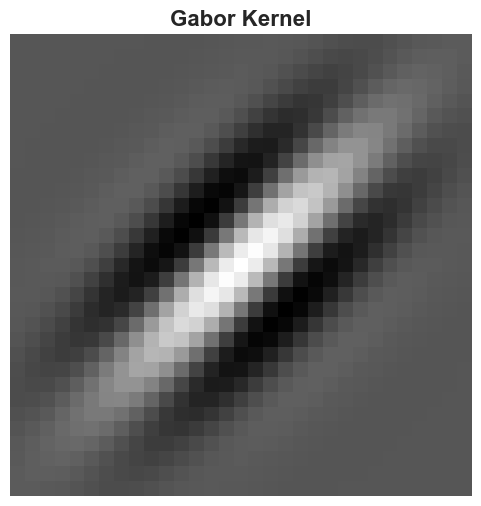

Gabor kernel shape: (31, 31)


In [6]:
# Visualize the Gabor kernel
gabor_kernel = cv2.getGaborKernel(
    (GABOR_KSIZE, GABOR_KSIZE), 
    GABOR_SIGMA, 
    GABOR_THETA, 
    GABOR_LAMBDA, 
    GABOR_GAMMA, 
    0, 
    ktype=cv2.CV_32F
)

plt.figure(figsize=(6, 6))
plt.imshow(gabor_kernel, cmap='gray')
plt.title('Gabor Kernel', fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

print("Gabor kernel shape:", gabor_kernel.shape)

### 3.3 Visualize Gabor Features on Sample Images

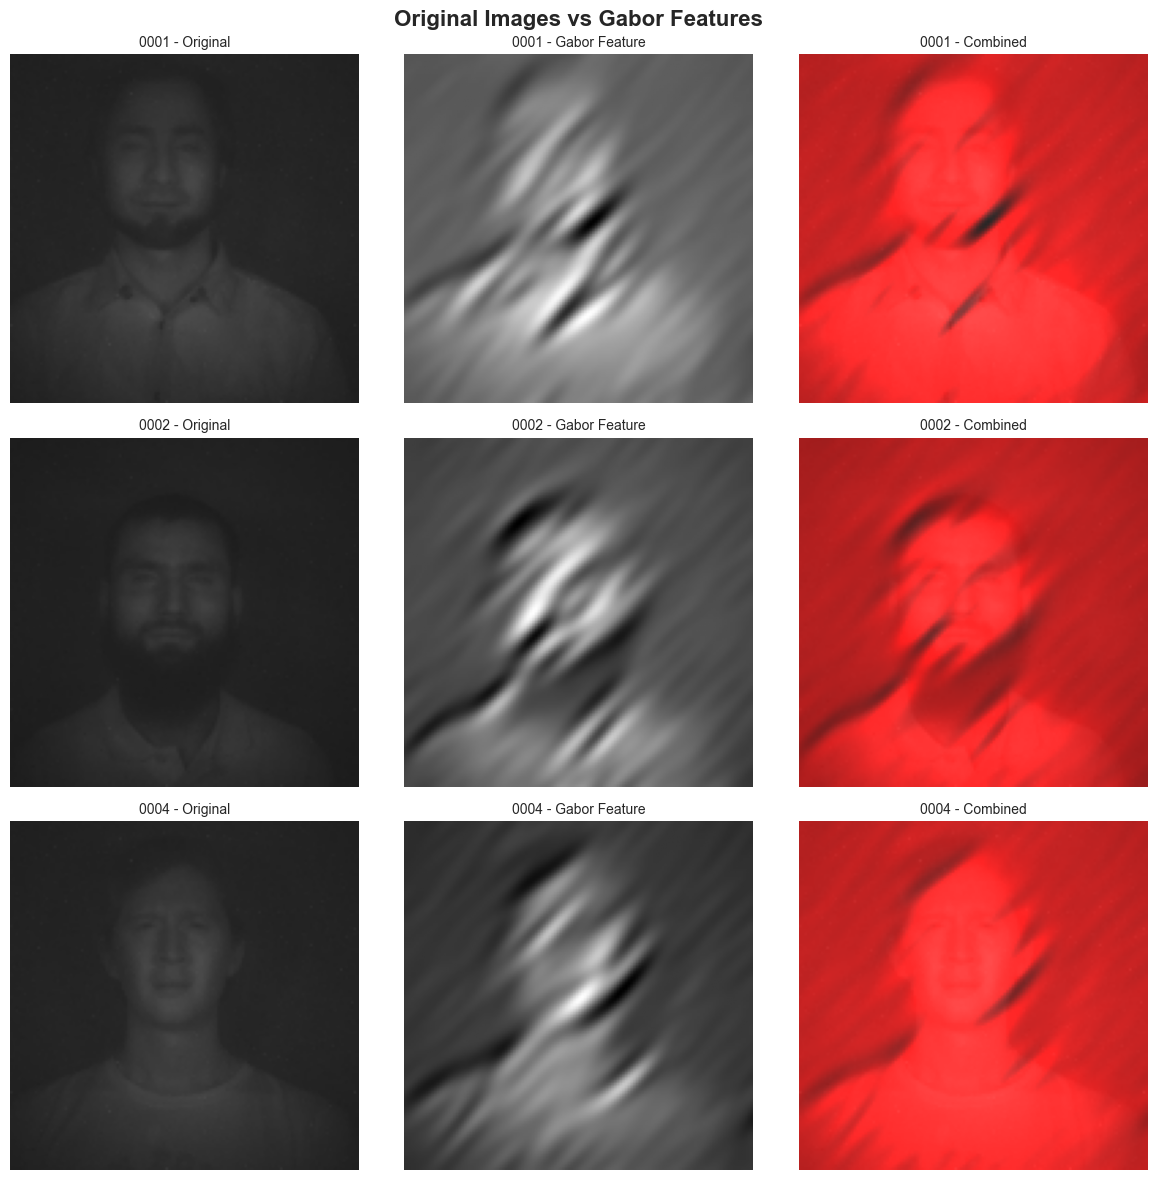

In [7]:
# Visualize Gabor features on sample images
num_samples_to_show = min(3, len(label_names))

fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(12, 4*num_samples_to_show))
fig.suptitle('Original Images vs Gabor Features', fontsize=16, fontweight='bold')

if num_samples_to_show == 1:
    axes = [axes]

for i in range(num_samples_to_show):
    # Find first occurrence of each class
    class_idx = np.where(y_encoded == i)[0]
    if len(class_idx) > 0:
        idx = class_idx[0]
        
        # Original image
        axes[i][0].imshow(X[idx][:, :, :3])
        axes[i][0].set_title(f'{label_names[i]} - Original', fontsize=10)
        axes[i][0].axis('off')
        
        # Gabor feature
        if USE_GABOR:
            axes[i][1].imshow(X[idx][:, :, 3], cmap='gray')
            axes[i][1].set_title(f'{label_names[i]} - Gabor Feature', fontsize=10)
            axes[i][1].axis('off')
            
            # Combined
            combined = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
            combined[:, :, :3] = X[idx][:, :, :3]
            combined[:, :, 0] += X[idx][:, :, 3] * 0.5  # Add to red channel for visualization
            combined = np.clip(combined, 0, 1)
            axes[i][2].imshow(combined)
            axes[i][2].set_title(f'{label_names[i]} - Combined', fontsize=10)
            axes[i][2].axis('off')

plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis <a id='eda'></a>

### 3.1 Dataset Statistics

In [8]:
# Create a DataFrame for analysis
df_analysis = pd.DataFrame({
    'label': y_labels,
    'label_encoded': y_encoded
})

# Count samples per class
class_distribution = df_analysis['label'].value_counts().sort_index()

print("Samples per class:")
print(class_distribution)
print(f"\nMean samples per class: {class_distribution.mean():.2f}")
print(f"Std samples per class: {class_distribution.std():.2f}")

Samples per class:
label
0001    33
0002    33
0004    33
0005    33
0006    33
        ..
0083    33
0084    33
0085    33
0086    33
0087    33
Name: count, Length: 78, dtype: int64

Mean samples per class: 33.00
Std samples per class: 0.00


### 3.2 Visualize Class Distribution

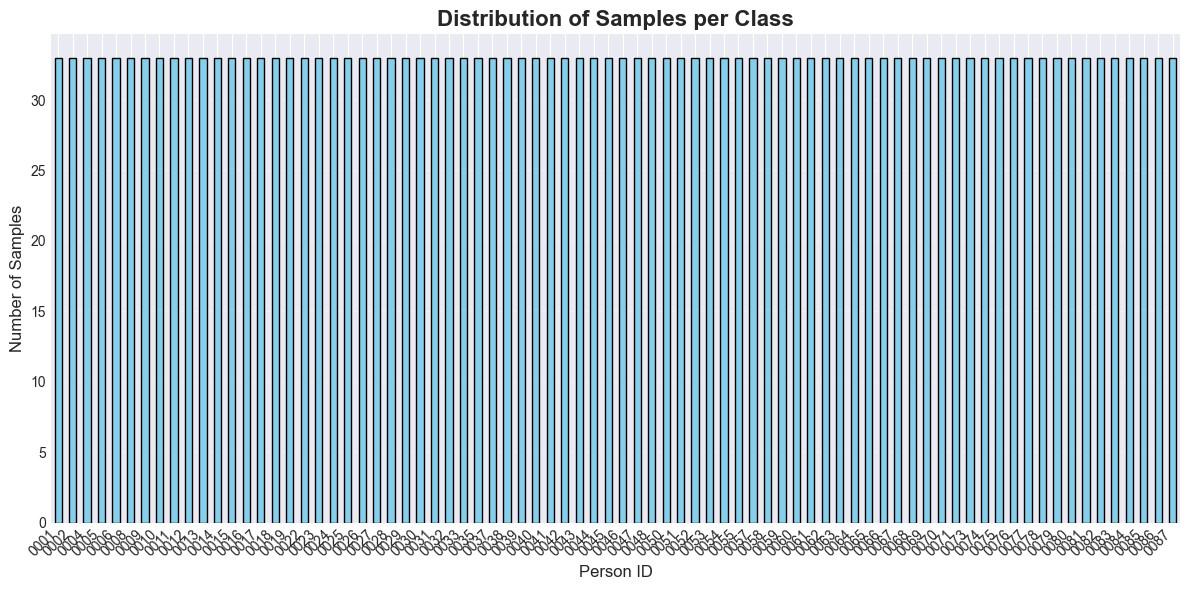

In [9]:
# Plot class distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

class_distribution.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Samples per Class', fontsize=16, fontweight='bold')
ax.set_xlabel('Person ID', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3.3 Visualize Sample Images

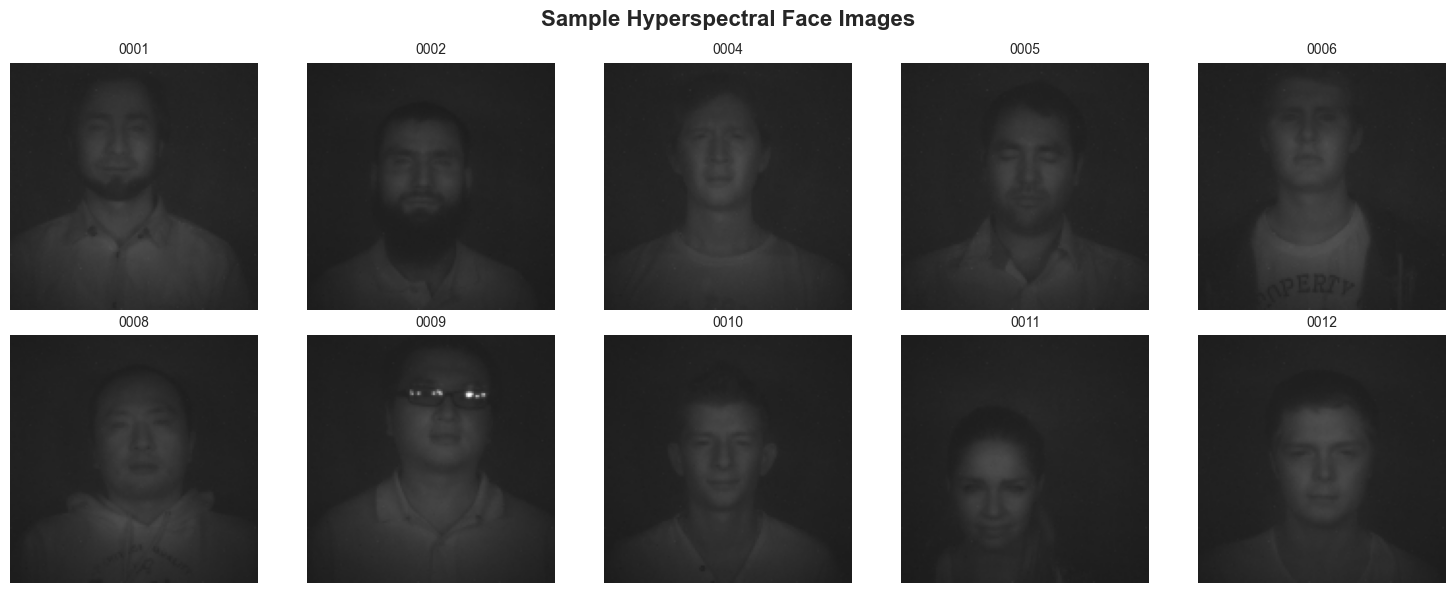

In [10]:
# Display sample images from different classes
num_samples_to_show = min(10, len(label_names))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Hyperspectral Face Images', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i in range(num_samples_to_show):
    # Find first occurrence of each class
    class_idx = np.where(y_encoded == i)[0]
    if len(class_idx) > 0:
        idx = class_idx[0]
        axes[i].imshow(X[idx][:, :, :3])
        axes[i].set_title(f'{label_names[i]}', fontsize=10)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## 4. Model Architecture

### 4.1 Build CNN Model for Hyperspectral Face Recognition


In [11]:
def build_face_recognition_model(input_shape, num_classes):
   
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, X.shape[3])
num_classes = len(label_names)

model = build_face_recognition_model(input_shape, num_classes)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,719,950 (37.08 MB)

 Trainable params: 9,716,494 (37.07 MB)

 Non-trainable params: 3,456 (13.50 KB)

### 4.2 Compile Model with Optimizer and Loss Function

In [12]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("Model compiled successfully!")
print(f"Input shape: {input_shape}")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Loss function: Categorical Crossentropy")
print(f"Metrics: Accuracy, Precision, Recall")

Model compiled successfully!
Input shape: (128, 128, 4)
Optimizer: Adam (lr=0.001)
Loss function: Categorical Crossentropy
Metrics: Accuracy, Precision, Recall


### 4.3 Setup Callbacks for Training

In [13]:
# Define callbacks for better training
checkpoint_callback = ModelCheckpoint(
    'best_face_recognition_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

print("Callbacks configured:")
print("- ModelCheckpoint: Save best model based on validation accuracy")
print("- EarlyStopping: Stop training if validation loss doesn't improve for 10 epochs")
print("- ReduceLROnPlateau: Reduce learning rate if validation loss plateaus")

Callbacks configured:
- ModelCheckpoint: Save best model based on validation accuracy
- EarlyStopping: Stop training if validation loss doesn't improve for 10 epochs
- ReduceLROnPlateau: Reduce learning rate if validation loss plateaus


## 5. Training <a id='training'></a>

### 5.1 Data Augmentation

To improve model generalization, we'll apply data augmentation techniques.

In [14]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation set
val_datagen = ImageDataGenerator()

print("Data augmentation configured:")
print("- Rotation: ±15 degrees")
print("- Width/Height shift: ±10%")
print("- Horizontal flip: Enabled")
print("- Zoom: ±10%")

Data augmentation configured:
- Rotation: ±15 degrees
- Width/Height shift: ±10%
- Horizontal flip: Enabled
- Zoom: ±10%


### 5.2 Train the Model

In [15]:
# Train the model
print("Starting model training...")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
print("\nTraining completed!")

Starting model training...
Training samples: 1647
Validation samples: 412
Batch size: 32
Epochs: 20
Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0167 - loss: 5.4719 - precision: 0.0208 - recall: 0.0012
Epoch 1: val_accuracy improved from -inf to 0.00971, saving model to best_face_recognition_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.0168 - loss: 5.4668 - precision: 0.0214 - recall: 0.0013 - val_accuracy: 0.0097 - val_loss: 5.2501 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0451 - loss: 4.5403 - precision: 0.1958 - recall: 0.0110
Epoch 2: val_accuracy improved from 0.00971 to 0.02427, saving model to best_face_recognition_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.0455 - loss: 4.5376 - precision: 0.1973 - recall: 0.0111 - val_accuracy: 0.0243 - val_loss: 5.4016 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate

### 5.3 Visualize Training History

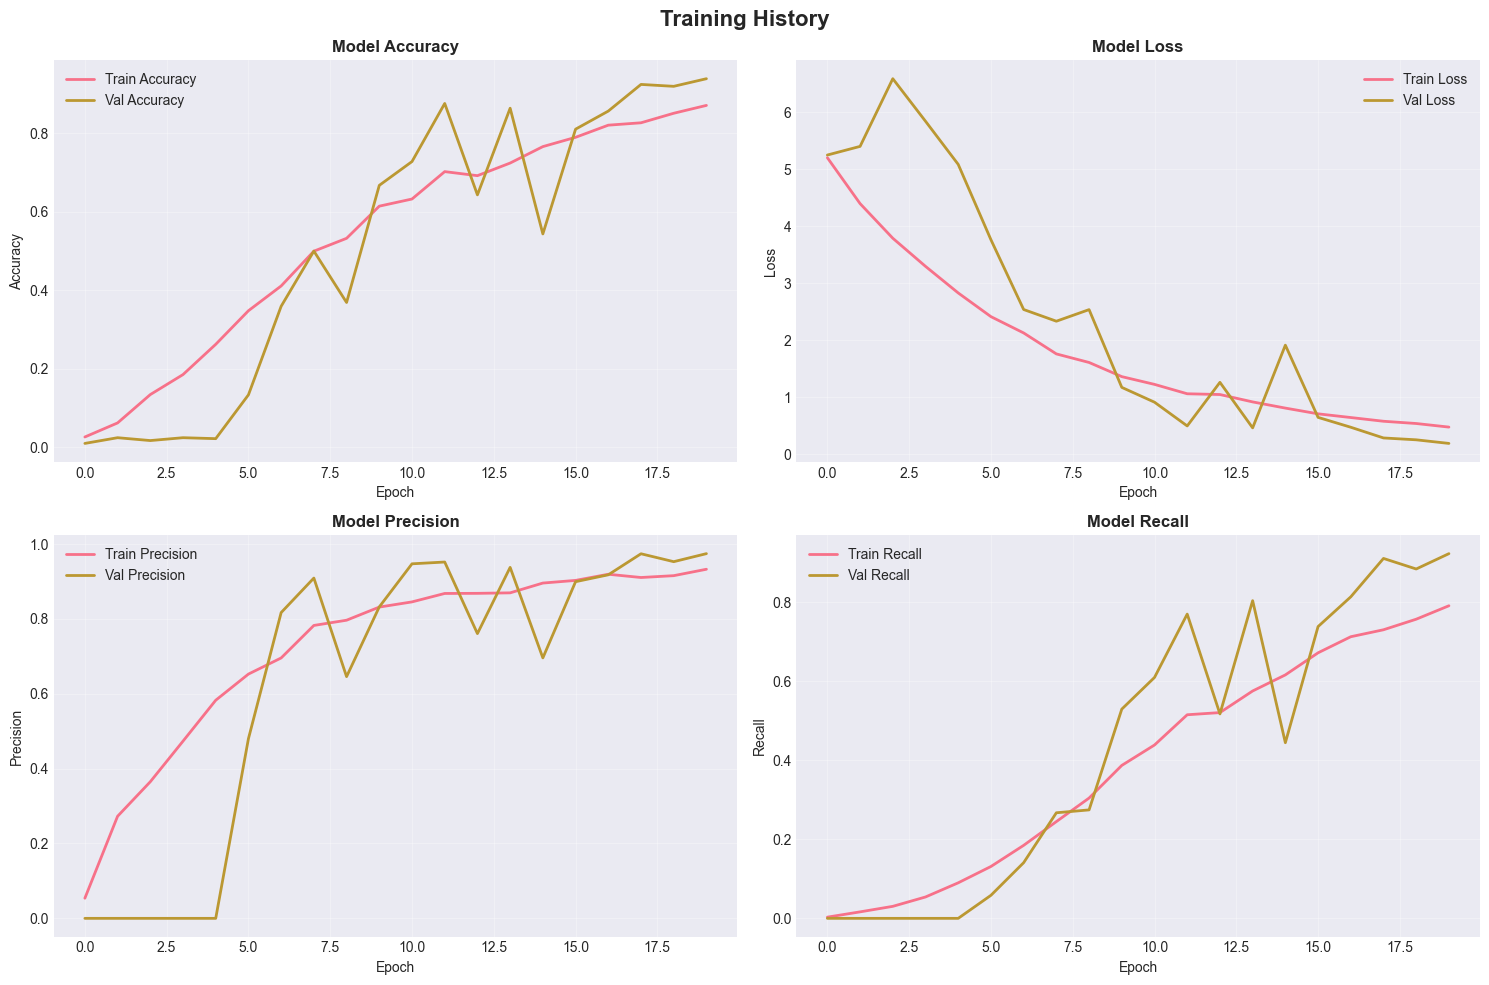

In [16]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=10)
axes[0, 0].set_ylabel('Accuracy', fontsize=10)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=10)
axes[0, 1].set_ylabel('Loss', fontsize=10)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
if 'precision' in history.history:
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=10)
    axes[1, 0].set_ylabel('Precision', fontsize=10)
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

# Recall
if 'recall' in history.history:
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=10)
    axes[1, 1].set_ylabel('Recall', fontsize=10)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Evaluation <a id='evaluation'></a>

### 6.1 Evaluate on Test Set

In [17]:
# Evaluate model on test set
print("Evaluating model on test set...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Set Performance:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

# Calculate F1 score
if test_precision > 0 and test_recall > 0:
    f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    print(f"F1 Score: {f1_score:.4f}")

# Print Gabor configuration summary
print(f"\nGabor Transform: {'Enabled' if USE_GABOR else 'Disabled'}")
if USE_GABOR:
    print(f"Input channels: {X.shape[3]}")
else:
    print(f"Input channels: {X.shape[3]}")

Evaluating model on test set...

Test Set Performance:
Loss: 0.2233
Accuracy: 0.9223 (92.23%)
Precision: 0.9630
Recall: 0.9087
F1 Score: 0.9351

Gabor Transform: Enabled
Input channels: 4


### 6.2 Generate Predictions and Confusion Matrix

In [18]:
# Make predictions on test set
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 0 ... 7 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 6]]


### 6.3 Detailed Classification Report

In [19]:
# Classification report
print("\nClassification Report:")
print("=" * 70)
report = classification_report(y_true, y_pred, target_names=label_names, digits=4)
print(report)

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

# Create DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Class': label_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-Class Metrics:")
print(metrics_df.to_string(index=False))


Classification Report:
              precision    recall  f1-score   support

        0001     1.0000    1.0000    1.0000         6
        0002     0.7778    1.0000    0.8750         7
        0004     1.0000    1.0000    1.0000         7
        0005     1.0000    0.8571    0.9231         7
        0006     1.0000    1.0000    1.0000         6
        0008     1.0000    1.0000    1.0000         6
        0009     1.0000    1.0000    1.0000         7
        0010     0.7500    1.0000    0.8571         6
        0011     1.0000    1.0000    1.0000         7
        0012     0.4286    1.0000    0.6000         6
        0013     0.6667    1.0000    0.8000         6
        0014     1.0000    1.0000    1.0000         7
        0015     1.0000    1.0000    1.0000         6
        0016     1.0000    1.0000    1.0000         7
        0017     1.0000    0.8571    0.9231         7
        0018     1.0000    1.0000    1.0000         7
        0019     1.0000    1.0000    1.0000         6
   

## 7. Visualization and Results <a id='visualization'></a>

### 7.1 Visualize Confusion Matrix

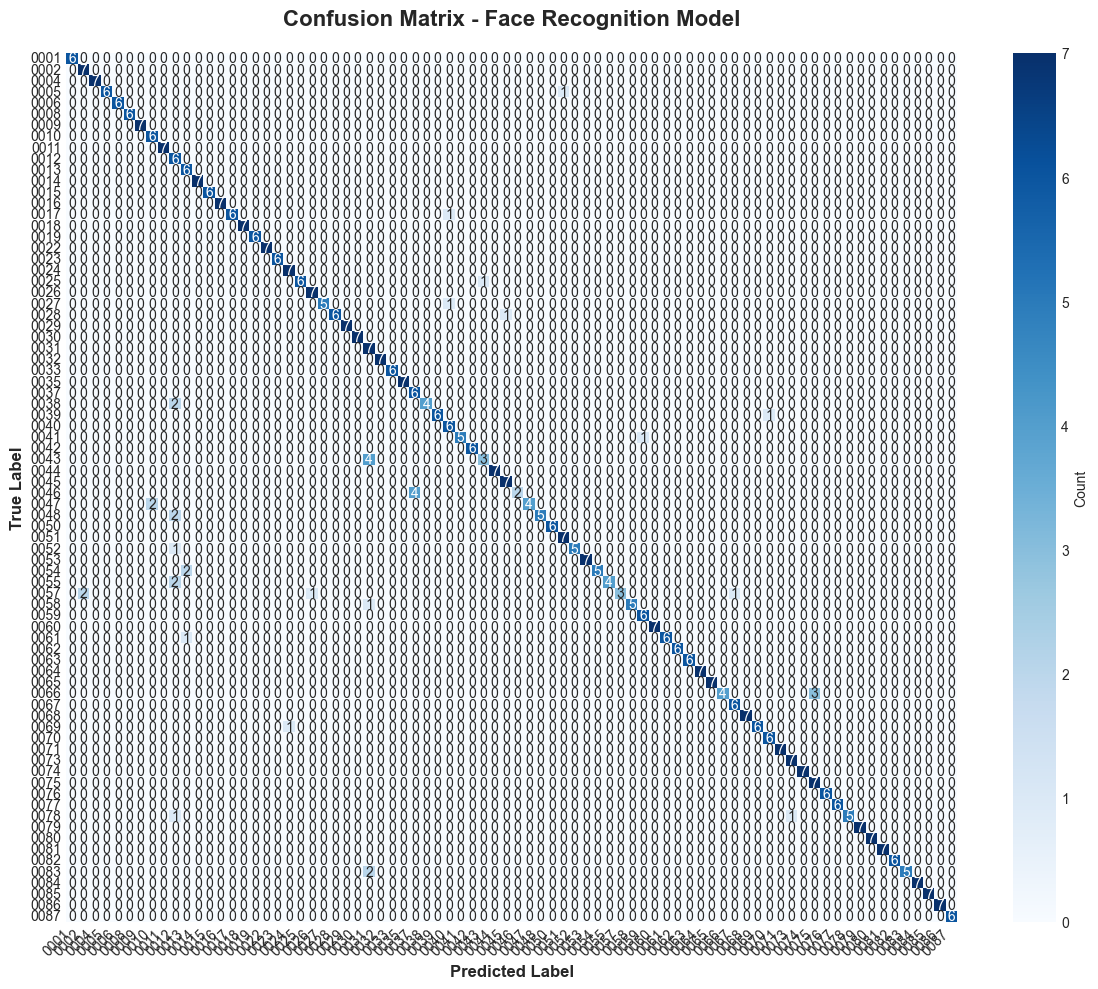

In [20]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Face Recognition Model', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 7.3 Visualize Sample Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011115116..10.582031].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.101960786..3.6280727].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00049345865..9.581428].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0013784503..8.250103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0003384432..5.148018].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039626984..5.4544125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0

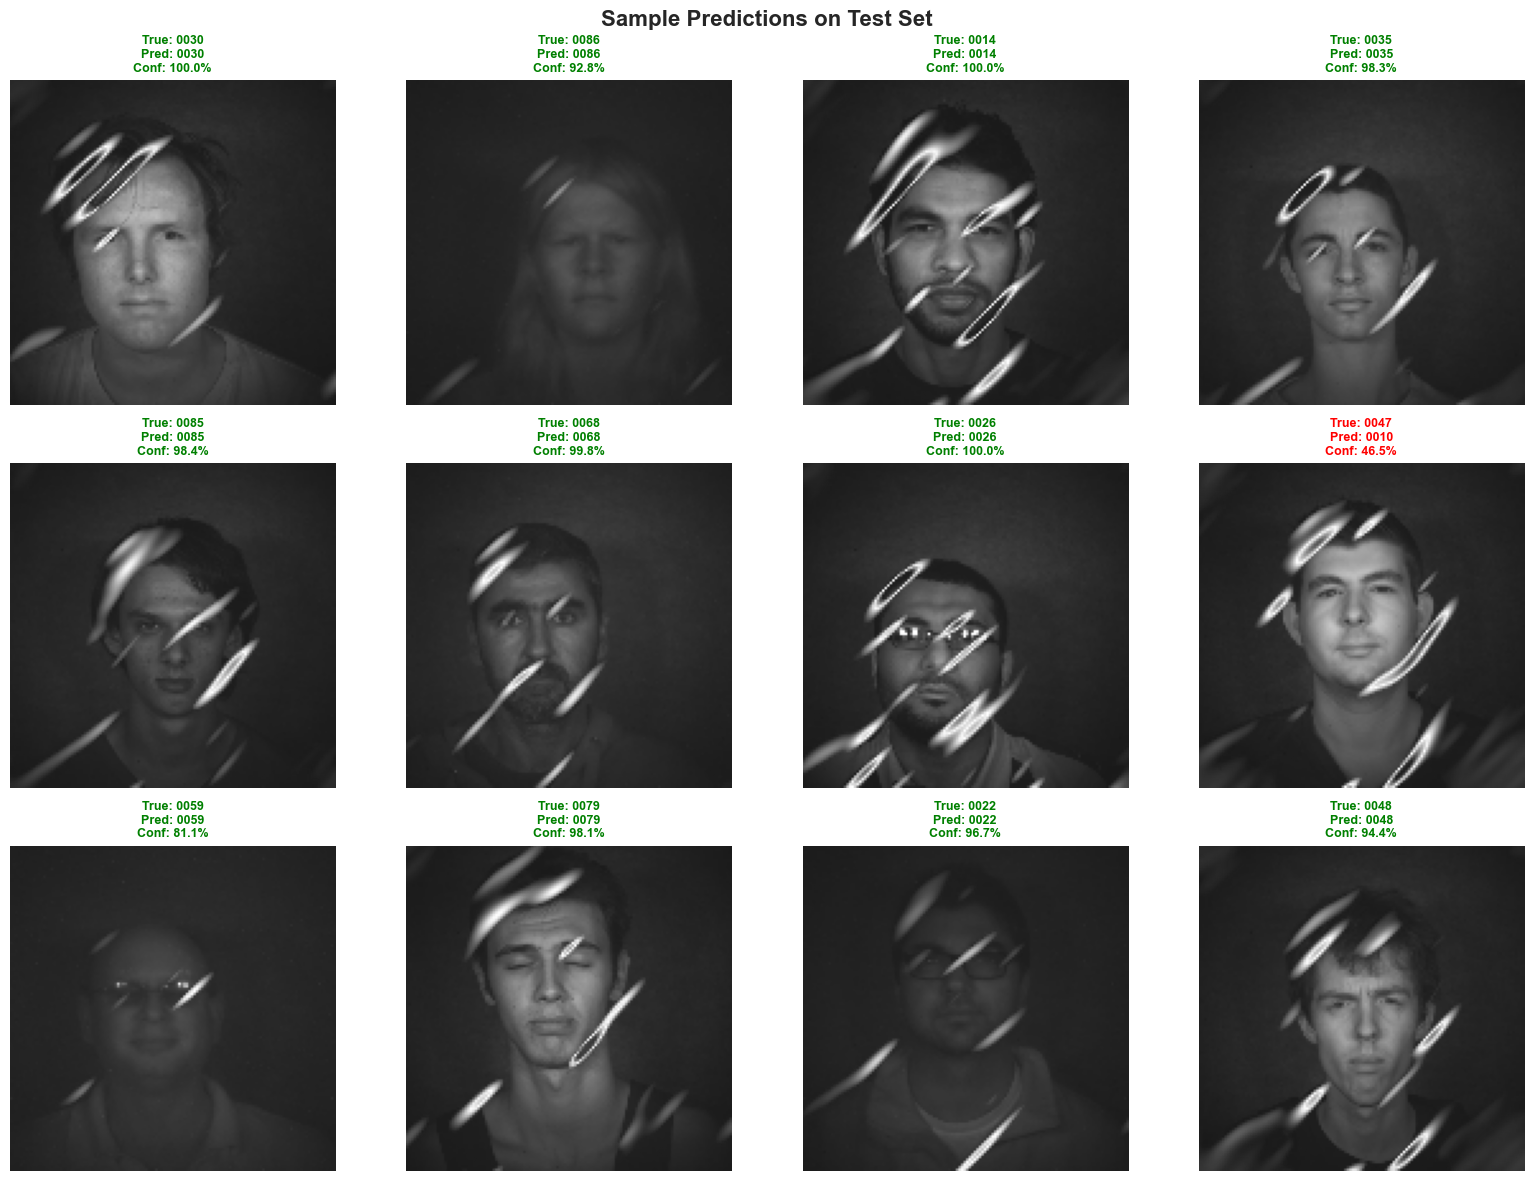

In [21]:
# Visualize sample predictions
num_samples = min(12, len(X_test))
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold')
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    axes[i].imshow(X_test[idx])
    
    true_label = label_names[y_true[idx]]
    pred_label = label_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]] * 100
    
    # Color code: green for correct, red for incorrect
    color = 'green' if y_true[idx] == y_pred[idx] else 'red'
    
    title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
    axes[i].set_title(title, fontsize=9, color=color, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 7.5 Model Performance Summary

In [23]:
# Create comprehensive performance summary
print("FINAL MODEL PERFORMANCE SUMMARY")

print(f"\nDataset Information:")
print(f"  - Total samples: {len(X)}")
print(f"  - Number of classes: {num_classes}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Validation samples: {len(X_val)}")
print(f"  - Test samples: {len(X_test)}")

print(f"\nModel Architecture:")
print(f"  - Input shape: {input_shape}")
print(f"  - Total parameters: {model.count_params():,}")
print(f"  - Convolutional blocks: 4")
print(f"  - Dense layers: 2")

print(f"\nTraining Configuration:")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Epochs trained: {len(history.history['loss'])}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Optimizer: Adam")

print(f"\nTest Set Performance:")
print(f"  - Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall: {test_recall:.4f}")
if test_precision > 0 and test_recall > 0:
    print(f"  - F1-Score: {f1_score:.4f}")
print(f"  - Loss: {test_loss:.4f}")



FINAL MODEL PERFORMANCE SUMMARY

Dataset Information:
  - Total samples: 2574
  - Number of classes: 78
  - Training samples: 1647
  - Validation samples: 412
  - Test samples: 515

Model Architecture:
  - Input shape: (128, 128, 4)
  - Total parameters: 9,719,950
  - Convolutional blocks: 4
  - Dense layers: 2

Training Configuration:
  - Batch size: 32
  - Epochs trained: 20
  - Learning rate: 0.001
  - Optimizer: Adam

Test Set Performance:
  - Accuracy: 0.9223 (92.23%)
  - Precision: 0.9630
  - Recall: 0.9087
  - F1-Score: 0.9351
  - Loss: 0.2233


### 7.6 Save Model for Deployment

In [28]:
# Save the final model
model.save('hyperspectral_face_recognition_model.keras')
print("Model saved as 'hyperspectral_face_recognition_model.keras'")

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved as 'label_encoder.pkl'")

Model saved as 'hyperspectral_face_recognition_model.keras'
Label encoder saved as 'label_encoder.pkl'
